Dataset : Heart

https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset/data

***
**DATA PREPARATION**
***

Sebelum memulai proses pemodelan kita akan memasuki tahapan data preparation atau data preprocessing. hal ini dilakukan untuk mempersiapkan data yang kita punya supaya siap untuk dilakukan pemodelan.

In [ ]:
#Import library python
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

langkah pertama adalah import library python yang akan digunakan selama proses pemodelan machine learning berlangsung.

In [ ]:
#Membaca dan menampilkan dataframe
df = pd.read_csv('heart.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


kemudian kita akan load/menampilkan dataset dalam bentuk DataFrame menggunakan library pandas.

In [ ]:
#Memeriksa missing value
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

setelah itu kita akan memeriksa apakah pada dataset tersebut terdapat nilai yang kosong (missing value) atau tidak. karena jika ada missing value pada suatu dataset, maka dapat memengaruhi proses pemodelan nantinya.

pada dataset yang digunakan di atas, terlihat tidak ada missing value yang terlihat. sehingga tidak memerlukan suatu penanganan.

In [ ]:
#Memeriksa tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Pada Dataset Heart dapat kita ketahui apabila memiliki tipe data integer dan float pada fitur oldpeak. namun, pada dataframe dapat kita lihat bahwa terdapat beberapa data kategorikal, diantaranya sex, cp, fbs, restecg, exang, oldpeak, slope, ca, dan thal. sedangkan data numerikal pada fitur age, chol, thalach, dan trestbps

In [ ]:
#Encoding data/mengubah data menjadi numerikal

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int', 'float']).columns.tolist()

print("Categorical column:", categorical_cols)
print("Numerical column:", numerical_cols)

Categorical column: []
Numerical column: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


Proses encoding dilakukan apabila pada dataset terdapat nilai kategorikal. namun, dari hasil di atas dapat terlihat apabila tidak ada data kategorikal. sehingga tidak diperlukan proses encoding kembali.

In [ ]:
#Memeriksa nilai duplikat
df.duplicated().sum()

723

In [ ]:
#Mengatasi nilai duplikat dan memeriksa kembali
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

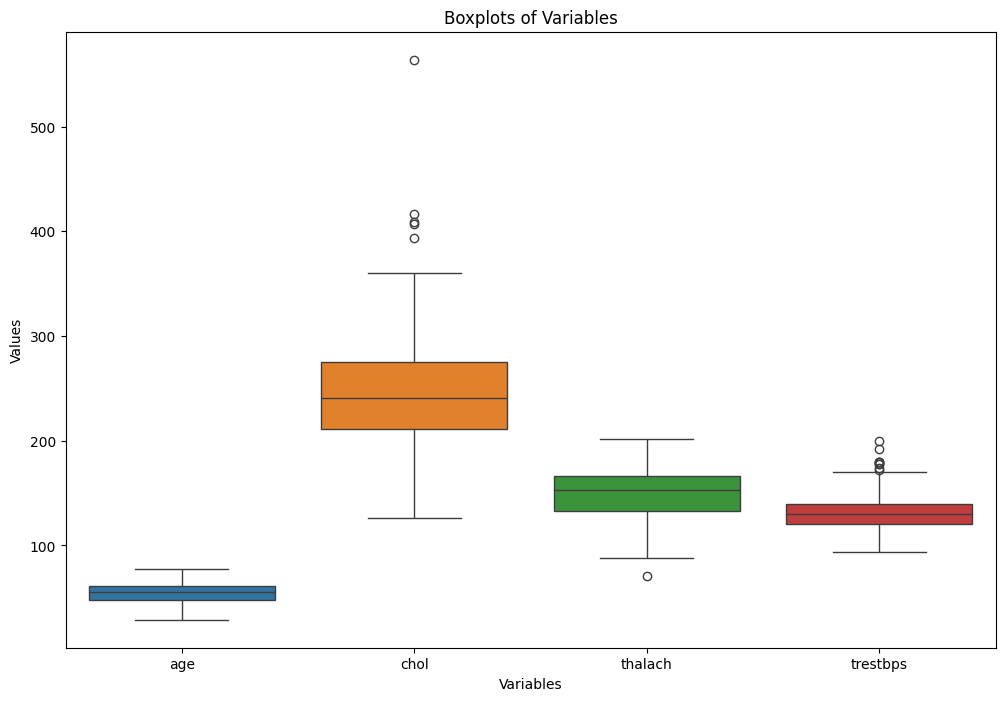

In [ ]:
#Memeriksa outlier pada fitur selain kategorikal, yaitu fitur age, chol, thalach, dan trestbps

plt.figure(figsize=(12, 8))
sns.boxplot(data=df[['age', 'chol', 'thalach', 'trestbps']])

# Add title and labels
plt.title('Boxplots of Variables')
plt.xlabel('Variables')
plt.ylabel('Values')

# Show the plot
plt.show()

Berdasarkan boxplot di atas, pada data numerikal terdapat pencilan atau outlier. outlier tersebut perlu ditangain agar tidak menimbulkan masalah pada saat proses analisis. penanganan outlier dapat menggunakan metode IQR (interquartile).

In [ ]:
#Handling Outlier menggunakan IQR (Interquartile)
for col in df.columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), df[col].mean(), df[col])

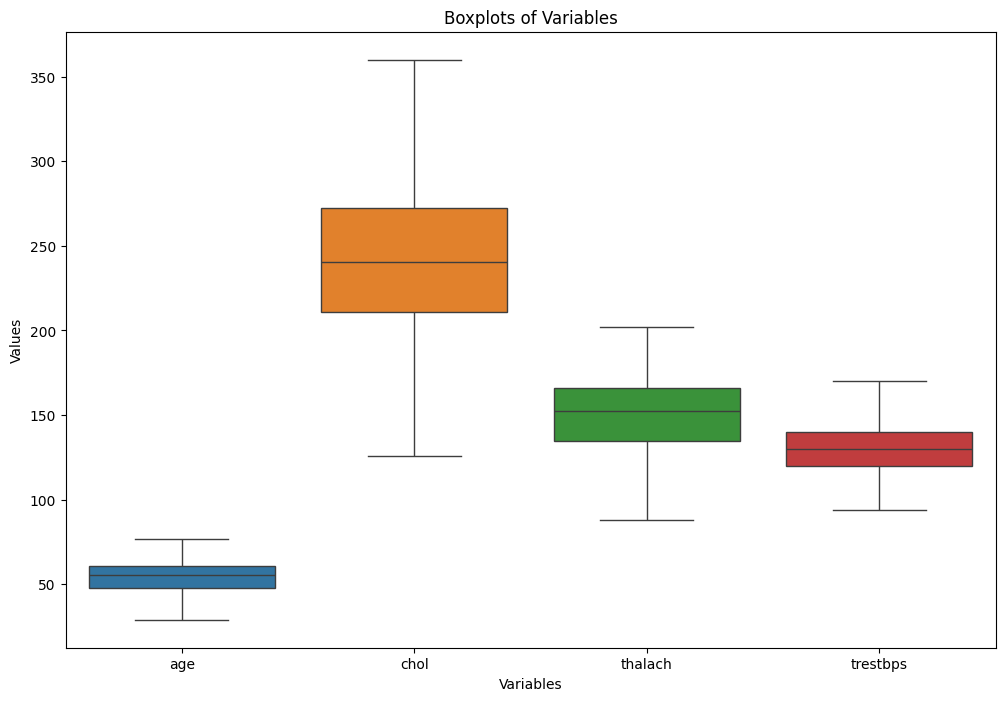

In [ ]:
#Memeriksa kembali outlier pada dataframe
plt.figure(figsize=(12, 8))

sns.boxplot(data=df[['age', 'chol', 'thalach', 'trestbps']])

plt.title('Boxplots of Variables')
plt.xlabel('Variables')
plt.ylabel('Values')

plt.show()

setalah ditangani menggunakan metode IQR, sudah tidak terlihat lagi adanya outlier pada data numerikal di atas

In [ ]:
#Handling Imbalance Data menggunakan metode SMOTE

# Pisahkan fitur dan target
X = df.drop('target', axis=1)
y = df['target']

# Bagi data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Terapkan oversampling menggunakan SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Tampilkan distribusi kelas sebelum resampling
print("Distribusi Kelas Sebelum Resampling:")
print(y_train.value_counts())

# Tampilkan distribusi kelas setelah resampling
print("\nDistribusi Kelas Setelah Resampling:")
print(y_train_resampled.value_counts())

Distribusi Kelas Sebelum Resampling:
target
1.0    135
0.0    106
Name: count, dtype: int64

Distribusi Kelas Setelah Resampling:
target
0.0    135
1.0    135
Name: count, dtype: int64


langkah di atas merupakan tahapan memeriksa imbalance data. imbalance data adalah jumlah data yang tidak seimbang pada variabel target. oleh karena itu, agar tidak terjadi adanya kesalahan pada proses modeling, data harus diseimbangkan.

dari hasil jumlah sampel perkelas di atas dapat terlihat apabila terdapat ketidakseimbangan jumlah data (imbalance).

***
**EXPLORATORY DATA ANALYSIS**
***

In [ ]:
#Memeriksa statistika deskriptif dari dataset heart
df.describe().round()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,302.0,302.0,302.0,302.0,302.0,302.0,302.0,302.0,302.0,302.0,302.0,302.0,302.0,302.0
mean,54.0,1.0,1.0,130.0,243.0,0.0,1.0,150.0,0.0,1.0,1.0,1.0,2.0,1.0
std,9.0,0.0,1.0,15.0,45.0,0.0,1.0,22.0,0.0,1.0,1.0,1.0,1.0,0.0
min,29.0,0.0,0.0,94.0,126.0,0.0,0.0,88.0,0.0,0.0,0.0,0.0,1.0,0.0
25%,48.0,0.0,0.0,120.0,211.0,0.0,0.0,134.0,0.0,0.0,1.0,0.0,2.0,0.0
50%,56.0,1.0,1.0,130.0,240.0,0.0,1.0,152.0,0.0,1.0,1.0,0.0,2.0,1.0
75%,61.0,1.0,2.0,140.0,272.0,0.0,1.0,166.0,1.0,2.0,2.0,1.0,3.0,1.0
max,77.0,1.0,3.0,170.0,360.0,0.0,2.0,202.0,1.0,4.0,2.0,2.0,3.0,1.0


Dari fungsi describe di atas bisa kita dapatkan nilai mean, modus, standard deviasi, nilai minimum, maximum, Quartile 1 (25%), Median/Quartile 2 (50%), dan Quartile 3 (75%) dari setiap fitur pada dataset heart

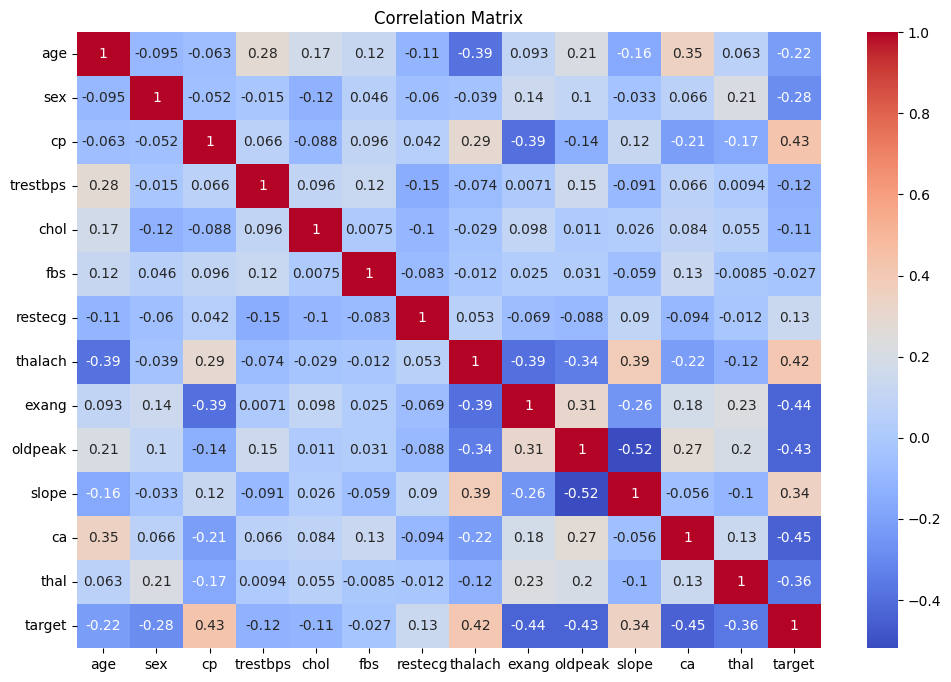

In [ ]:
#Memeriksa korelasi antar fitur pada dataset heart
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

plt.show()

correlation matrix di atas menunjukkan hubungan antara 1 fitur dengan fitur yang lain. semakin menjauhi angka 0, maka kedua fitur memiliki korelasi. apabila menuju angka 1, maka fitur tersebut memiliki korelasi positif, sebaliknya apabila meuju angka -1 maka fitur tersebut memiliki korelasi negatif.

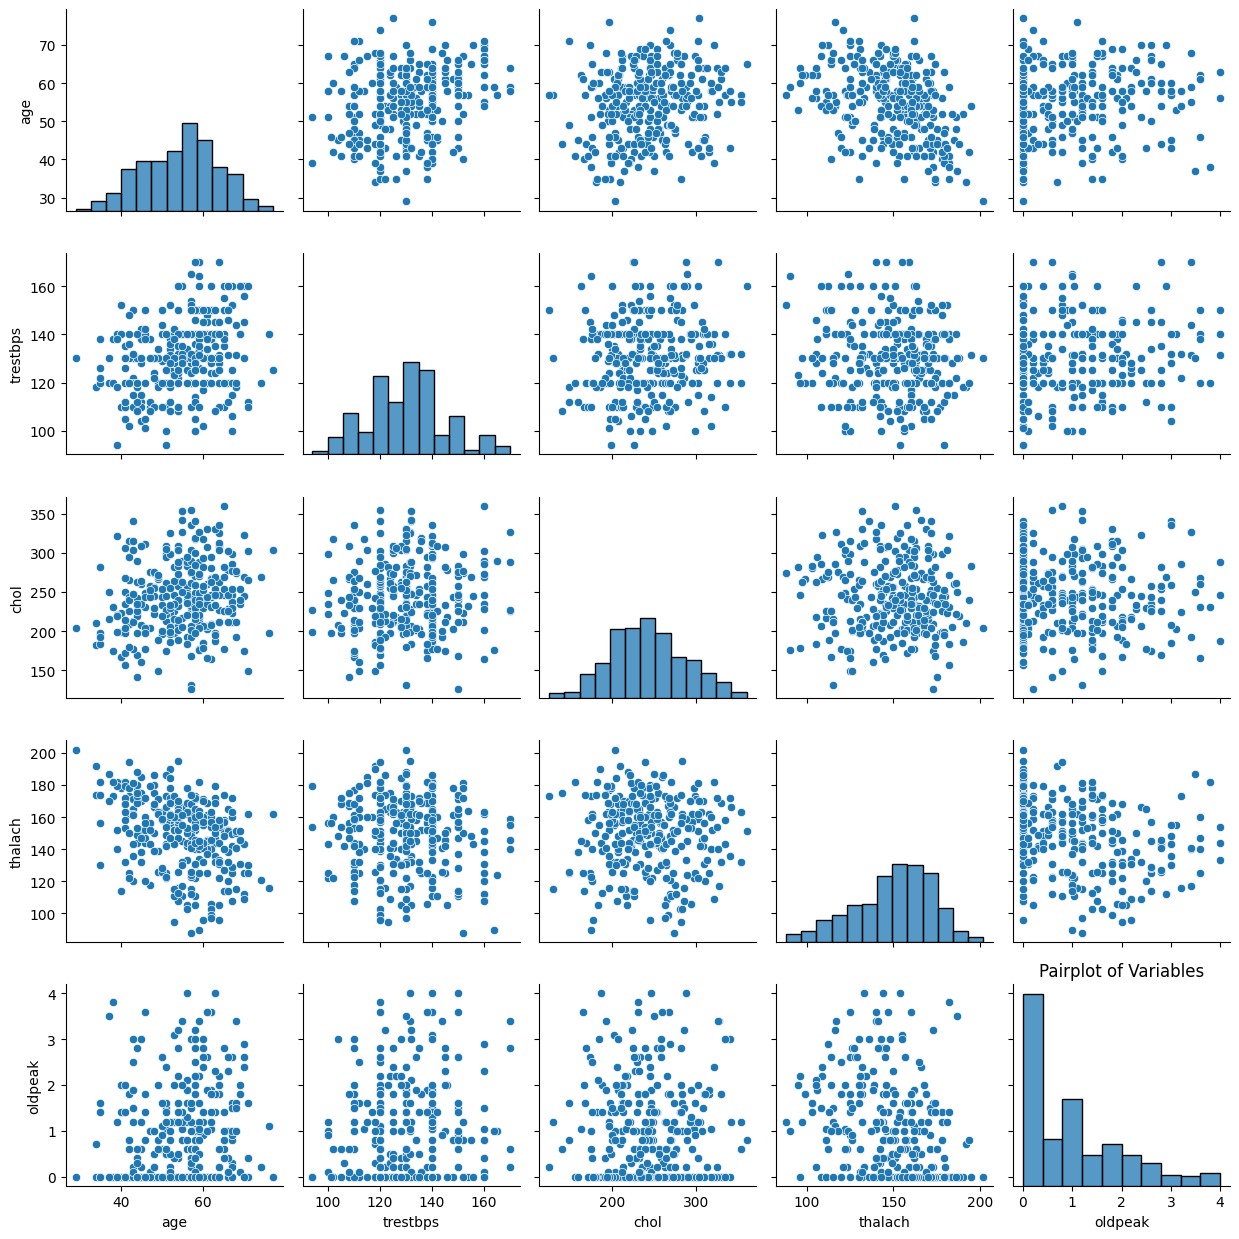

In [ ]:
#Memeriksa distribusi data melalui visualisasi pairplot pada fitur selain yang memiliki tipe data kategorikal
num_features = ['age', 'trestbps', 'chol','thalach', 'oldpeak']
sns.pairplot(df[num_features])
plt.title('Pairplot of Variables')
plt.tight_layout()
plt.show()

***
**SCALING DATA**
***

In [ ]:
#Memisahkan data atribut(X) dengan data label(Y)
X = df.drop(columns=['target'])
Y = df['target']

langkah pertama pada saat melakukan scaling data adalah memisahkan antara variabel target dengan variabel atributnya. disini, variabel target akan dimisalkan dengan Y, dan variabel lainnya dengan X.

In [ ]:
#Melakukan scalling dengan menggunakan metode MinMax Scaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[0.47916667, 1.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.5       , 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.85416667, 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.47916667, 1.        , 0.        , ..., 1.        , 0.5       ,
        1.        ],
       [0.625     , 1.        , 1.        , ..., 1.        , 0.        ,
        0.5       ],
       [0.52083333, 1.        , 0.        , ..., 0.5       , 0.5       ,
        1.        ]])

setelah itu kita akan menggunakan metode minmax scaler untuk melakukan scaling. scaling dilakukan dengan tujuan untuk menyamaratakan nilai pada dataset agar selisih dari setiap data tidak terlalu jauh.

In [ ]:
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.479167,1.0,0.0,0.407895,0.367521,0.0,0.5,0.701754,0.0,0.250,1.0,1.000000,1.0
1,0.500000,1.0,0.0,0.605263,0.329060,1.0,0.0,0.587719,1.0,0.775,0.0,0.000000,1.0
2,0.854167,1.0,0.0,0.671053,0.205128,0.0,0.5,0.324561,1.0,0.650,0.0,0.000000,1.0
3,0.666667,1.0,0.0,0.710526,0.329060,0.0,0.5,0.640351,0.0,0.000,1.0,0.500000,1.0
4,0.687500,0.0,0.0,0.578947,0.717949,1.0,0.5,0.157895,0.0,0.475,0.5,0.359272,0.5


DataFrame di atas merupakan hasil dari transformasi minmax scaling pada setiap atribut/fitur pada dataset heart.

In [ ]:
#Membagi data menjadi data training dan data testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=0)

Sebelum melakukan pemodelan, langkah terakhir yang dilakukan adalah membagi dataset menjadi 2, yaitu data pelatihan (data train) dan data pengujian (data testing). hal ini dilakukan untuk melakukan uji coba pada data untuk mendapatkan hasil pemodelan yang baik dan maksimal.

In [ ]:
X_train.shape, X_test.shape

((241, 13), (61, 13))

In [ ]:
y_train.shape, y_test.shape

((241,), (61,))

sehingga di dapatkan ukuran dari data training dan data testing seperti output di atas

***
**PEMODELAN**
***

**Decision tree**

Decision tree dipilih sebagai pemodelan dataset heart (prediksi penyakit jantung) karena algoritma dari decision tree seperti struktur pohon pengambil keputusan. hal ini merupakan representasi dari seorang dokter yang mengambil keputusan penyakit pasien berdasarkan diagnosis yang muncul pada diri seorang pasien. Dengan demikian, decision tree memberikan cara yang intuitif untuk mewakili kompleksitas hubungan antara fitur-fitur yang mempengaruhi penyakit jantung.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

dt = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=6)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0)

Langkah pertama pada saat melakukan pemodelan menggunakan decission tree adalah memanggil library yang akan digunakan. disini kita dapat menggunakan modul decision tree classifier dari library sckitlearn.

langkah selanjutnya kita akan memanggil modul tersebut dengan parameter yang akan kita gunakan, seperti criterion, jumlah random state, dan max depth.

setelah itu kita akan melakukan pemodelan menggunakan fungsi .fit dengan variabel training.


In [ ]:
#Melakukan prediksi pada data testing
y_pred = dt.predict(X_test)

#Menghitung confusion matrix untuk mengevaluasi kinerja model
dt_conf_matrix = confusion_matrix(y_test, y_pred)

#Menghitung akurasi model
dt_accuracy = accuracy_score(y_test, y_pred)

#Menampilkan confusion matrix
print("Confusion Matrix:", '\n', dt_conf_matrix, '\n')

# Menampilkan akurasi model
print("Nilai Akurasi untuk model RandomForestClassifier:", dt_accuracy, '\n')

# Menampilkan laporan klasifikasi yang mencakup precision, recall, F1-score, dan support
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix: 
 [[19  6]
 [ 7 29]] 

Nilai Akurasi untuk model RandomForestClassifier: 0.7868852459016393 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.76      0.75        25
         1.0       0.83      0.81      0.82        36

    accuracy                           0.79        61
   macro avg       0.78      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



Pada tahapan di atas, kita melakukan prediksi terhadap data testing yang disimpan pada variabel y_pred.

kemudian kita akan menghitung nilai confussion matrix dengan nilai yang ada pada variabel y_pred.

kita juga akan menghitung nilai akurasi dari pemodelan yang dilakukan. dan di dapatkan nilai akurasinya sebesar 0.79 atau 79%.

selain itu, juga ditampilkan classification report yang berisi nilai precision, recall, dan f1-score

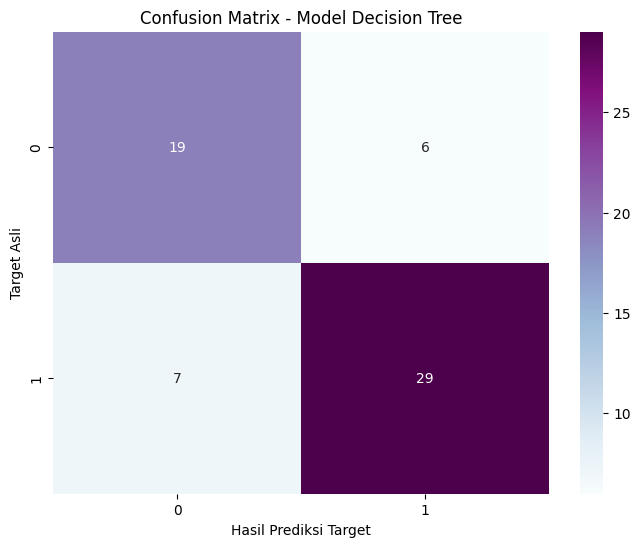

In [ ]:
#Membuat heatmap dengan persentase
plt.figure(figsize=(8, 6))
sns.heatmap(dt_conf_matrix, annot=True, fmt='d', cmap='BuPu', cbar=True, )
plt.title("Confusion Matrix - Model Decision Tree")
plt.xlabel("Hasil Prediksi Target")
plt.ylabel("Target Asli")
plt.show()

selanjutnya kita akan membuat confusion matriks untuk mengevaluasi hasil kinerja dari model klasifikasi decision tree yang kita gunakan.

dari hasil matriks tersebut didapatkan
nilai True Positive (TP) = 7
nilai False Positive (FP) = 19
nilai True Negative (TN) = 6
nilai False Negative (FN) = 29

yang mana memiliki arti adalah sebanyak 7 orang mendapatkan diagnosa memiliki penyakit jantung dan memang memiliki penyakit jantung, 19 orang terdiagnosa tetapi ternyata tidak memiliki penyakit jantung, 6 orang sehat yang artinya tidak terdiagnosa dan tidak memiliki penyakit jantung, dan 29 orang tidak terdiagnosa tetapi ternyata memiliki penyakit jantung.

In [ ]:
#Melakukan cross validation
cvscore = cross_val_score(dt, X_train, y_train, cv=10, scoring='accuracy')

Tahapan ini kita akan menggunakan metode cross validation untuk mengukur seberapa baik kinerja model pada data yang tidak dgunakan dalam proses pelatihan.

pada cross validation yang dijalankan di atas, dataset akan dibagi menjadi 10 fold.

In [ ]:
cvscore.mean()

0.7478333333333333

kita akan memeriksa nilai rata-rata dari cross validation yang sedang dijalankan

In [ ]:
cvscore.std()

0.09075623639422496

selain itu kita juga menampilkan nilai standar deviasi dari cross validation

In [ ]:
#Learning Curve
def Learning_curve_model(X, Y, model, cv, train_sizes):

    plt.figure()
    plt.title("Learning curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=cv, n_jobs=4, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

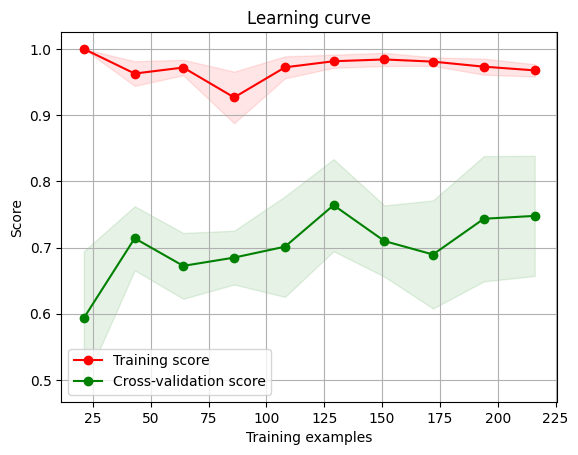

In [ ]:
cv = 10
train_size=np.linspace(.1, 1.0, 10)
Learning_curve_model(X_train, y_train, dt, cv, train_size)

Setelah kita melakukan cross validation, kita akan membuat kurva pembelajaran untuk melihat bagaimana kinerja model kita ketika jumlah data latih/data train berubah.

disini kita akan menggunakan data train dari dataset, dan data validation dari nilai cross validation menggunakan 10 nilai/titik.

sehingga didapatkan bahwa model mengalami **overfitting**. hal tersebut bisa diketahui karena terjadi kesenjangan jarak antara grafik training dan grafik validation.

In [ ]:
#Melakukan hyperparameter tuning
hyperparameters = {"max_depth":(5, 15, 30, 50, 65, 80), "max_features":(0.2, 0.1, 0.4, 0.6, 0.8), "min_samples_split":(2, 5, 8, 10, 20)}
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)
opt = RandomizedSearchCV(estimator=dt, param_distributions=hyperparameters, n_iter=50, cv=skf, scoring="accuracy", n_jobs=-1)

Karena kita memiliki nilai akurasi yang belum cukup memuaskan dengan kinerja model pembelajaran juga masih mengalami overfitting. kita akan melakukan hyperparameter tuning. hal ini bertujuan untuk kita dapat menentukan parameter yang tepat untuk pemodelan yang sedang dijalankan. disini kita akan menggunakan metode RandomizedSearchCV dengan StratifiedKFold.

In [ ]:
opt.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=15, shuffle=True),
                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=6,
                                                    random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': (5, 15, 30, 50, 65, 80),
                                        'max_features': (0.2, 0.1, 0.4, 0.6,
                                                         0.8),
                                        'min_samples_split': (2, 5, 8, 10, 20)},
                   scoring='accuracy')

disini kita akan dapatkan informasi pemodelan kita sebelum dilakukan hyperparameter

In [ ]:
opt.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features=0.8,
                       min_samples_split=20, random_state=0)

disini kita akan dapatkan estimator terbaik yang sudah dilakukan tuning


In [ ]:
opt.best_score_

0.7931666666666668

disini akan ditampilkan berapa nilai terbaik dari estimator yang telah terpilih

In [ ]:
opt.best_params_

{'min_samples_split': 20, 'max_features': 0.8, 'max_depth': 15}

disini akan ditampilkan parameter terbaik setelah dilakukannya hyperparameter tuning

In [ ]:
all_results = pd.DataFrame(opt.cv_results_)
all_results[(all_results["param_max_depth"]==15) & (all_results["param_max_features"]==0.8) & (all_results["param_min_samples_split"]==2)]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
44,0.003018,0.000947,0.001218,0.000055,2,0.8,15,"{'min_samples_split': 2, 'max_features': 0.8, ...",0.56,0.75,...,0.75,0.875,0.875,0.666667,0.833333,0.833333,0.708333,0.764333,0.094658,6


sehingga akan didapatkan hasil dari hyperparamter tuning seperti DataFrame di atas

**Remodeling Decision Tree Classifier**
***

In [ ]:
dt2 = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=65, min_samples_split=20, max_features=0.6)
dt2.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=65, max_features=0.6,
                       min_samples_split=20, random_state=0)

setelah melalui tahapan hyperparameter tuning maka didapatkan nilai parameter terbaik seperti di atas. kemudian kita akan menyesuaikannya dan melakukan pemodelan kembali menggunakan parameter yang terbaru.

In [ ]:
#Melakukan prediksi pada data testing
y_pred2 = dt2.predict(X_test)

#Menghitung confusion matrix untuk mengevaluasi kinerja model
dt2_conf_matrix = confusion_matrix(y_test, y_pred)

#Menghitung akurasi model
dt2_accuracy = accuracy_score(y_test, y_pred)

#Menampilkan confusion matrix
print("Confusion Matrix:", '\n', dt2_conf_matrix, '\n')

# Menampilkan akurasi model
print("Nilai Akurasi untuk model RandomForestClassifier:", dt2_accuracy, '\n')

# Menampilkan laporan klasifikasi yang mencakup precision, recall, F1-score, dan support
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix: 
 [[19  6]
 [ 7 29]] 

Nilai Akurasi untuk model RandomForestClassifier: 0.7868852459016393 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.76      0.75        25
         1.0       0.83      0.81      0.82        36

    accuracy                           0.79        61
   macro avg       0.78      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



tahapan pemodelan sama seperti pemodelan sebelumnya. sehingga didapatkan nilai akurasi sebesar 0.79 atau 79%.

**Kesimpulan**

nilai akurasi dari model Decision Tree Classifier adalah 79%.
hal ini dapat dilihat dari kedua pemodelan yang sudah dilakukan, baik sebelum dilakukannya hyperparameter tuning maupun sesudah, nilai akurasi tetap menunjukkan angka 79%.

***
**Random Forest Classifier**

Random Forest memiliki konsep algoritma yang menggabungkan prediksi dari beberapa decision tree yang berbeda. Dengan cara ini, Random Forest mampu mengurangi variabilitas dan meningkatkan kestabilan prediksi.

Dengan menggunakan Random Forest, kita dapat memperoleh prediksi yang lebih andal dan konsisten dalam memprediksi penyakit jantung, sambil tetap mempertahankan kemudahan interpretasi yang dimiliki oleh decision tree. Dengan demikian, Random Forest dapat memberikan peningkatan performa dan keandalan dibandingkan dengan menggunakan decision tree tunggal, menjadikannya pilihan yang baik untuk pemodelan prediksi penyakit jantung.


In [ ]:
#Melakukan scalling dengan menggunakan metode StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
x_test = scaler.fit_transform(X_test)

setelah itu kita akan menggunakan metode StandardScaler untuk melakukan scaling. scaling dilakukan dengan tujuan untuk menstandarisasi atau menyamaratakan nilai pada dataset. agar selisih dari setiap data tidak terlalu jauh.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

Langkah pertama pada saat melakukan pemodelan menggunakan decission tree adalah memanggil library yang akan digunakan. disini kita dapat menggunakan modul decision tree classifier dari library sckitlearn.

setelah itu kita akan melakukan pemodelan menggunakan fungsi .fit dengan variabel training.


In [ ]:
#Melakukan prediksi pada data testing
y_pred = rfc.predict(X_test)

#Menghitung confusion matrix untuk mengevaluasi kinerja model
rfc_conf_matrix = confusion_matrix(y_test, y_pred)

#Menghitung akurasi model
rfc_accuracy = accuracy_score(y_test, y_pred)

#Menampilkan confusion matrix
print("Confusion Matrix:", '\n', rfc_conf_matrix, '\n')

# Menampilkan akurasi model
print("Nilai Akurasi untuk model RandomForestClassifier:", rfc_accuracy, '\n')

# Menampilkan laporan klasifikasi yang mencakup precision, recall, F1-score, dan support
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix: 
 [[19  6]
 [ 6 30]] 

Nilai Akurasi untuk model RandomForestClassifier: 0.8032786885245902 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76        25
         1.0       0.83      0.83      0.83        36

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61



Sama seperti model decision tree, pada tahapan di atas, kita melakukan prediksi terhadap data testing yang disimpan pada variabel y_pred.

kemudian kita akan menghitung nilai confussion matrix dengan nilai yang ada pada variabel y_pred.

kita juga akan menghitung nilai akurasi dari pemodelan yang dilakukan. dan di dapatkan nilai akurasinya sebesar 0.85 atau 85%.

selain itu, juga ditampilkan classification report yang berisi nilai precision, recall, dan f1-score

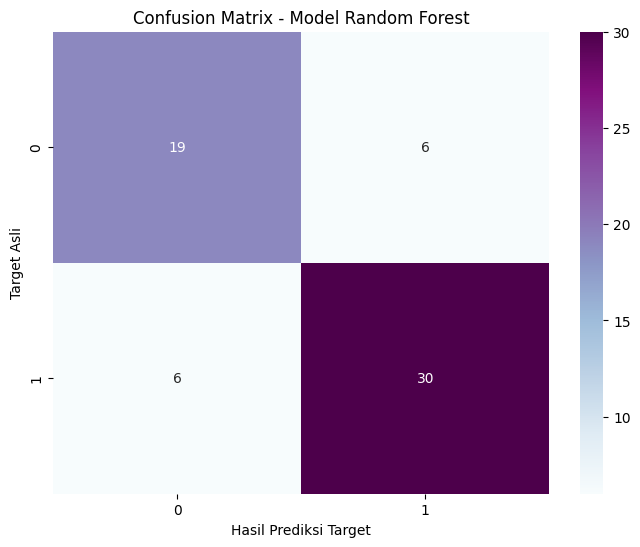

In [ ]:
#Membuat heatmap dengan persentase
plt.figure(figsize=(8, 6))
sns.heatmap(rfc_conf_matrix, annot=True, fmt='d', cmap='BuPu', cbar=True, )
plt.title("Confusion Matrix - Model Random Forest")
plt.xlabel("Hasil Prediksi Target")
plt.ylabel("Target Asli")
plt.show()

selanjutnya kita akan membuat confusion matriks untuk mengevaluasi hasil kinerja dari model klasifikasi decision tree yang kita gunakan.

dari hasil matriks tersebut didapatkan
nilai True Positive (TP) = 3
nilai False Positive (FP) = 19
nilai True Negative (TN) = 6
nilai False Negative (FN) = 33

yang mana memiliki arti adalah sebanyak 3 orang mendapatkan diagnosa memiliki penyakit jantung dan memang memiliki penyakit jantung, 19 orang terdiagnosa tetapi ternyata tidak memiliki penyakit jantung, 6 orang sehat yang artinya tidak terdiagnosa dan tidak memiliki penyakit jantung, dan 33 orang tidak terdiagnosa tetapi ternyata memiliki penyakit jantung.

In [ ]:
#Melakukan cross validation
from sklearn.model_selection import cross_val_score

cvscore = cross_val_score(rfc, X_train, y_train, cv=10)

Tahapan ini kita akan menggunakan metode cross validation untuk mengukur seberapa baik kinerja model pada data yang tidak dgunakan dalam proses pelatihan.

pada cross validation yang dijalankan di atas, dataset akan dibagi menjadi 10 fold.

In [ ]:
cvscore.mean()

0.7975000000000001

kita akan memeriksa dan mendapatkan nilai rata-rata dari cross validation

In [ ]:
cvscore.std()

0.0863656631872747

kita akan memeriksa dan mendapatkan nilai standard deviasi dari cross validation

In [ ]:
#Learning Curve
from sklearn.model_selection import learning_curve
def Learning_curve_model(X, Y, model, cv, train_sizes):

    plt.figure()
    plt.title("Learning curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=cv, n_jobs=4, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

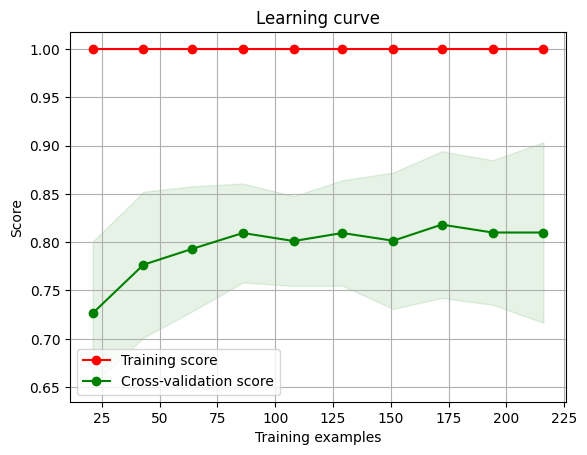

In [ ]:
cv = 10
train_size=np.linspace(.1, 1.0, 10)
Learning_curve_model(X_train, y_train, rfc, cv, train_size)

Setelah kita melakukan cross validation, kita akan membuat kurva pembelajaran untuk melihat bagaimana kinerja model kita ketika jumlah data latih/data train berubah.

disini kita akan menggunakan data train dari dataset, dan data validation dari nilai cross validation menggunakan 10 nilai/titik.

sehingga didapatkan bahwa model terlihat normal atau **goodfit**. hal tersebut bisa diketahui karena grafik dari training score dan validation tidak terlalu jauh. karena nilai akhir dari validation score terletak diatas nilai 80%. sehingga masih dapat dikatakan pemodelan yang baik.

In [ ]:
#Melakukan hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

hyperparameters = {"max_depth":(5, 15, 30, 50, 65, 80), "max_features":(0.2, 0.4, 0.6, 0.8), "min_samples_split":(2, 5, 8, 10, 20)}
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)
opt = GridSearchCV(estimator=rfc, param_grid=hyperparameters, cv=skf, scoring="accuracy", n_jobs=-1)

Karena kita memiliki nilai akurasi yang belum cukup memuaskan walaupun dengan kinerja model pembelajaran juga normal. kita akan mencoba untuk melakukan hyperparameter tuning. hal ini bertujuan untuk kita dapat menentukan parameter yang tepat untuk pemodelan yang sedang dijalankan. disini kita akan menggunakan metode GridSearchCV dengan StratifiedKFold.

In [ ]:
opt.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=15, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': (5, 15, 30, 50, 65, 80),
                         'max_features': (0.2, 0.4, 0.6, 0.8),
                         'min_samples_split': (2, 5, 8, 10, 20)},
             scoring='accuracy')

disini kita akan dapatkan informasi pemodelan kita sebelum dilakukan hyperparameter

In [ ]:
opt.best_estimator_

RandomForestClassifier(max_depth=30, max_features=0.2, min_samples_split=10)

disini kita akan dapatkan estimator terbaik yang sudah dilakukan tuning


In [ ]:
opt.best_score_

0.8549999999999999

disini akan ditampilkan berapa nilai terbaik dari estimator yang telah terpilih

In [ ]:
opt.best_params_

{'max_depth': 30, 'max_features': 0.2, 'min_samples_split': 10}

disini akan ditampilkan parameter terbaik setelah dilakukannya hyperparameter tuning

In [ ]:
pd.DataFrame(opt.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.249173,0.008098,0.011679,0.001907,5,0.2,2,"{'max_depth': 5, 'max_features': 0.2, 'min_sam...",0.76,0.916667,...,0.875000,0.958333,0.833333,0.791667,0.791667,0.875000,0.791667,0.838500,0.061723,8
1,0.243983,0.007605,0.010473,0.001092,5,0.2,5,"{'max_depth': 5, 'max_features': 0.2, 'min_sam...",0.76,0.875000,...,0.875000,0.958333,0.875000,0.791667,0.833333,0.833333,0.791667,0.838500,0.055814,8
2,0.242683,0.007885,0.010701,0.001283,5,0.2,8,"{'max_depth': 5, 'max_features': 0.2, 'min_sam...",0.80,0.916667,...,0.916667,0.916667,0.833333,0.750000,0.833333,0.833333,0.750000,0.834167,0.061288,19
3,0.263264,0.047660,0.013133,0.008127,5,0.2,10,"{'max_depth': 5, 'max_features': 0.2, 'min_sam...",0.76,0.916667,...,0.833333,0.958333,0.833333,0.708333,0.791667,0.875000,0.750000,0.821833,0.073758,49
4,0.407863,0.069247,0.014376,0.005926,5,0.2,20,"{'max_depth': 5, 'max_features': 0.2, 'min_sam...",0.76,0.875000,...,0.916667,0.916667,0.833333,0.708333,0.791667,0.875000,0.791667,0.826000,0.065601,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.275933,0.006242,0.010116,0.000950,80,0.8,2,"{'max_depth': 80, 'max_features': 0.8, 'min_sa...",0.68,0.833333,...,0.750000,0.916667,0.875000,0.708333,0.833333,0.791667,0.708333,0.784667,0.074419,120
116,0.274286,0.007638,0.010142,0.000503,80,0.8,5,"{'max_depth': 80, 'max_features': 0.8, 'min_sa...",0.72,0.875000,...,0.708333,0.791667,0.875000,0.750000,0.833333,0.791667,0.791667,0.788667,0.055756,116
117,0.276640,0.015213,0.010150,0.000971,80,0.8,8,"{'max_depth': 80, 'max_features': 0.8, 'min_sa...",0.72,0.833333,...,0.791667,0.916667,0.875000,0.750000,0.875000,0.833333,0.750000,0.809500,0.063364,79
118,0.268411,0.008117,0.009824,0.000233,80,0.8,10,"{'max_depth': 80, 'max_features': 0.8, 'min_sa...",0.72,0.791667,...,0.750000,0.875000,0.875000,0.791667,0.875000,0.833333,0.750000,0.801167,0.056579,102


In [ ]:
all_results = pd.DataFrame(opt.cv_results_)
all_results[(all_results["param_max_depth"]==15) & (all_results["param_max_features"]==0.8) & (all_results["param_min_samples_split"]==2)]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
35,0.273958,0.009664,0.010376,0.001222,15,0.8,2,"{'max_depth': 15, 'max_features': 0.8, 'min_sa...",0.72,0.833333,...,0.75,0.875,0.916667,0.791667,0.833333,0.791667,0.75,0.801167,0.059568,102


sehingga akan didapatkan hasil dari hyperparamter tuning seperti DataFrame di atas

Remodeling Random Forest Classifier
***

In [ ]:
rfc2 = RandomForestClassifier(max_depth=80, max_features=0.2, min_samples_split=10)
rfc2.fit(X_train, y_train)

RandomForestClassifier(max_depth=80, max_features=0.2, min_samples_split=10)

setelah melalui tahapan hyperparameter tuning maka didapatkan nilai parameter terbaik seperti di atas. kemudian kita akan menyesuaikannya dan melakukan pemodelan kembali menggunakan parameter yang terbaru.

In [ ]:
#Melakukan prediksi pada data testing
y_pred = rfc2.predict(X_test)

#Menghitung confusion matrix untuk mengevaluasi kinerja model
rfc2_conf_matrix = confusion_matrix(y_test, y_pred)

#Menghitung akurasi model
rfc2_accuracy = accuracy_score(y_test, y_pred)

#Menampilkan confusion matrix
print("Confusion Matrix:", '\n', rfc2_conf_matrix, '\n')

# Menampilkan akurasi model
print("Nilai Akurasi untuk model RandomForestClassifier:", rfc2_accuracy, '\n')

# Menampilkan laporan klasifikasi yang mencakup precision, recall, F1-score, dan support
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix: 
 [[19  6]
 [ 4 32]] 

Nilai Akurasi untuk model RandomForestClassifier: 0.8360655737704918 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.76      0.79        25
         1.0       0.84      0.89      0.86        36

    accuracy                           0.84        61
   macro avg       0.83      0.82      0.83        61
weighted avg       0.84      0.84      0.83        61



tahapan pemodelan sama seperti pemodelan sebelumnya. akan tetapi terjadi perubahan nilai akurasi setelah dilakukannya hyperparameter tuning. dengan nilai akurasi sebelum dilakukan tuning adalah 85% dan setelah dilakukan tuning adalah 82%.  Turunnya akurasi tersebut bukan menunjukkan hyperparameter tuning yang kita lakukan gagal, melainkan hyperparameter tuning yang kita lakukan berhasil karena dengan begitu model menjadi sedikit lebih general atau tidak overfitting.

***
**KESIMPULAN**
***

berdasarkan uji coba pemodelan menggunakan model Decision Tree Classifier dan Random Forest Classifier dalam mengolah dataset heart, maka didapatkan bahwa model yang paling baik adalah **Random Forest Classifier dengan nilai akurasi sebesar 82%**, sedangkan Decision Tree adalah 79%.